In [1]:
import numpy as np
import json
import glob
import os
from pyspark.ml.feature import StringIndexer
import time
import seaborn as sns
import sqlite3
import matplotlib.pyplot as plt 
import matplotlib.cm as cm

In [2]:
import os
import sys

os.environ["JAVA_HOME"] = "C:/Program Files/Java/jdk-19"
os.environ["SPARK_HOME"] = "C:/Users/slavi/OneDrive - NVIDIA Corporation/Documents/GitHub/Big-data/spark-3.3.1-bin-hadoop3"
os.environ["HADOOP_HOME"] = "C:/Users/slavi/OneDrive - NVIDIA Corporation/Documents/GitHub/Big-data/hadoop-3.0.0"

In [3]:
import findspark
import random
import pyspark
from pyspark.sql import functions as f
from pyspark.sql import SparkSession
findspark.init()

In [4]:
# initiaiting spark context
sc = pyspark.SparkContext("local", appName="MillionSongs")

In [5]:
# open data directly from file
spark = SparkSession(sc)
df = spark.read.csv("MILLION_SONGS.csv", inferSchema=True, header=True)
df = df.drop('transfer_note', 'Unnamed: 0', 'artist_7digitalid', 'artist_mbid', 'artist_mbtags', 'artist_mbtags_count', 'artist_playmeid', 'audio_md5', 'danceability', 'energy', 'release_7digitalid', 'similar_artists', 'song_id', 'track_7digitalid', 'analysis_sample_rate')

In [6]:
df = df.withColumn("artist_familiarity",f.col("artist_familiarity").cast("int"))
artist_fam_med = df.approxQuantile("artist_familiarity",[0.5],0)

In [7]:
df = df.fillna({'artist_familiarity':artist_fam_med[0]})
df = df.na.fill({'artist_location':''})
df = df.na.fill({'artist_name':''})
df = df.na.fill({'release':''})
df = df.na.fill({'title':''})

In [8]:
## Droping NaN for song_hotness
df = df.dropna(how='any',subset='song_hotttnesss')

In [9]:
# Encode artist id and release
art_indexer = StringIndexer(inputCol='artist_id', outputCol='artist_idIndex')
rel_indexer = StringIndexer(inputCol='release', outputCol='releaseIndex')

In [10]:
df = art_indexer.fit(df).transform(df) 
df = rel_indexer.fit(df).transform(df)

In [11]:
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- artist_familiarity: integer (nullable = true)
 |-- artist_hotttnesss: string (nullable = true)
 |-- artist_id: string (nullable = true)
 |-- artist_latitude: string (nullable = true)
 |-- artist_longitude: string (nullable = true)
 |-- artist_location: string (nullable = false)
 |-- artist_name: string (nullable = false)
 |-- release: string (nullable = false)
 |-- song_hotttnesss: string (nullable = true)
 |-- title: string (nullable = false)
 |-- artist_terms: string (nullable = true)
 |-- artist_terms_freq: string (nullable = true)
 |-- artist_terms_weight: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- end_of_fade_in: string (nullable = true)
 |-- key: string (nullable = true)
 |-- key_confidence: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- mode_confidence: string (nullable = true)
 |-- start_of_fade_out: string (nullable = true)
 |-- tempo: string (null

In [12]:
df.coalesce(1).write.mode('overwrite').csv('cleaned_data',header='true')

Py4JJavaError: An error occurred while calling o152.csv.
: org.apache.spark.SparkException: Job aborted.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.jobAbortedError(QueryExecutionErrors.scala:651)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:278)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:186)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:113)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:111)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.executeCollect(commands.scala:125)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.$anonfun$applyOrElse$1(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:109)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:169)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:95)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:779)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:94)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:584)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(TreeNode.scala:176)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:584)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:560)
	at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:94)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted$lzycompute(QueryExecution.scala:81)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:79)
	at org.apache.spark.sql.execution.QueryExecution.assertCommandExecuted(QueryExecution.scala:116)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:860)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:390)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:363)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:239)
	at org.apache.spark.sql.DataFrameWriter.csv(DataFrameWriter.scala:851)
	at java.base/jdk.internal.reflect.DirectMethodHandleAccessor.invoke(DirectMethodHandleAccessor.java:104)
	at java.base/java.lang.reflect.Method.invoke(Method.java:578)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1589)
Caused by: java.lang.UnsatisfiedLinkError: 'boolean org.apache.hadoop.io.nativeio.NativeIO$Windows.access0(java.lang.String, int)'
	at org.apache.hadoop.io.nativeio.NativeIO$Windows.access0(Native Method)
	at org.apache.hadoop.io.nativeio.NativeIO$Windows.access(NativeIO.java:793)
	at org.apache.hadoop.fs.FileUtil.canRead(FileUtil.java:1218)
	at org.apache.hadoop.fs.FileUtil.list(FileUtil.java:1423)
	at org.apache.hadoop.fs.RawLocalFileSystem.listStatus(RawLocalFileSystem.java:601)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:1972)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:2014)
	at org.apache.hadoop.fs.ChecksumFileSystem.listStatus(ChecksumFileSystem.java:761)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:1972)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:2014)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.getAllCommittedTaskPaths(FileOutputCommitter.java:334)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.commitJobInternal(FileOutputCommitter.java:404)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.commitJob(FileOutputCommitter.java:377)
	at org.apache.spark.internal.io.HadoopMapReduceCommitProtocol.commitJob(HadoopMapReduceCommitProtocol.scala:192)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.$anonfun$write$25(FileFormatWriter.scala:267)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.timeTakenMs(Utils.scala:642)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:267)
	... 40 more


<AxesSubplot:ylabel='Frequency'>

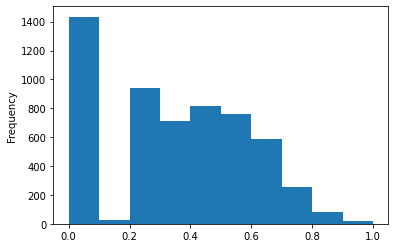

In [7]:
df['song_hotttnesss'].plot(kind='hist')

In [124]:
sc.stop()